# 1. Import libraries

In [1]:
import re
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

import xgboost
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50000)

# 2. Import data

In [2]:
df = pd.read_csv('data/dataset.csv')

# 3. Employer Title

In [3]:
def emp_title(data, pattern, category_name):
    """
    Find patterns and return a list with the common category name for 
    different patterns. For eg: If 'Walmart' appears in the following 
    formats ('walmart', 'Wal-Mart', 'Walmart') it will be set to Walmart.
    """
    unique_names = data['emp_title'].unique() 
    matches = [pattern.findall(i) for i in unique_names if len(pattern.findall(i)) > 0]
    matches = [item for l in matches for item in l]
    return [category_name if i in matches else i for i in data['emp_title']]


def emp_title_patterns(data, col_name):
    """
    This function applies manually identified patterns of most common 
    employer title and replace the remaining with Others!!
    """
    
    # US Army
    pattern = re.compile(r'[a-zA-Z\S]*^[uU][a-zA-Z\s\S]+[Aa][Rr][Mm][Yy][a-zA-Z\S]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'U.S. Army')

    # US Navy
    pattern = re.compile(r'^[uU][a-zA-Z\s\S]+[Nn][Aa][Vv][Yy][a-zA-Z\S]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'U.S. Navy')

    # Walmart
    pattern = re.compile(r'^[Ww][Aa][a-zA-Z\S]+[tT]$[a-zA-Z\S]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'Walmart')

    # Banks
    pattern = re.compile(r'[a-zA-Z\S\s]*[Bb][Aa][Nn][Kk][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'Banks')

    # AT&T
    pattern = re.compile(r'[a-zA-Z\S\s]*[Aa][Tt][&n][Tt][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'AT&T')

    # Air Force
    pattern = re.compile(r'[a-zA-Z\S\s]*Force[a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'Air Force')

    # USPS
    pattern = re.compile(r'^[Uu][a-zA-Z\S\s]*[Pp][Oo][Ss][Tt][Aa][Ll][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'USPS')

    # USPS
    pattern = re.compile(r'^[Uu][Ss][Pp][Ss]')
    data.loc[:,col_name] = emp_title(data, pattern, 'USPS')

    # Chase Bank
    pattern = re.compile(r'[a-zA-Z\S\s]*[Cc]hase[a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'J.P. Morgan Chase')

    # IBM
    pattern = re.compile(r'[a-zA-Z\S\s]*[Ii][Bb][Mm][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'IBM')

    # University
    pattern = re.compile(r'[a-zA-Z\S\s]*[Uu][Nn][Ii][Vv][Ee][Rr][Ss][Ii][Tt][Yy][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'University')

    # Airlines
    pattern = re.compile(r'[a-zA-Z\S\s]*[Aa]irline[s]*[a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'Airlines')

    # The Home Depot
    pattern = re.compile(r'[a-zA-Z\S\s]*[Hh][Oo][Mm][Ee]\s[Dd][Ee][Pp][Oo][Tt][a-zA-Z\S\s]*')
    data.loc[:,col_name] = emp_title(data, pattern, 'The Home Depot')

    # Other
    top_category = ['None', 'Banks', 'University', 'U.S. Army', 'Air Force', 'USPS', 'Airlines', 'Walmart', 'J.P. Morgan Chase', 'IBM', 'U.S. Navy', 'The Home Depot', 'AT&T']
    data.loc[:,col_name] = ['Other' if i not in top_category else i for i in data.loc[:,col_name]] 
    
    return data[col_name]

# 4. Notes

In [4]:
def lambda_nltk_notes(data, col_names):

    data.loc[:, col_names] = data[col_names].fillna('None')
    stop_words = stopwords.words('english')
    stop_words.append('br/')
    special_char = re.compile(r'[\W]')
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    sample = []
    for index, note in enumerate(data[col_names]):
        word_tokens = word_tokenize(note)
        no_stops = [i for i in word_tokens if i.lower() not in stop_words]
        no_special = [special_char.sub('',i) for i in no_stops if special_char.sub('',i) != '']
#         stem_lemma = " ".join(ps.stem(lemmatizer.lemmatize(i.lower())) for i in no_special)
        stem_lemma = " ".join(i.lower() for i in no_special)
        sample.append(stem_lemma)

    return sample


# 5. Data Preprocessing

In [5]:
def data_preprocessiong(data):
    
    # emp_title - CATEGORICAL
    data.loc[:,'emp_title'] = data['emp_title'].fillna('None')
    data.loc[:,'emp_title'] = emp_title_patterns(data, 'emp_title')
    
    # emp_length - NUMERICAL
    data.loc[:,'emp_length'] = [0 if i == 'na' else i for i in data['emp_length']]
    data.loc[:,'emp_length'] = data['emp_length'].astype(int)
    
    # home_ownership - CATEGORICAL
    data.drop(data.loc[data['home_ownership']=='NONE', :].index, inplace=True)
    
    # annual_inc - NUMERICAL
    data.loc[:,'annual_inc'] = data['annual_inc'].fillna(0)
    
    # verification_status - CATEGORICAL
    
    # Notes - TEXT
    data.loc[:,'Notes'] = lambda_nltk_notes(data, 'Notes')
    data.loc[:,'Notes'] = data['Notes'].astype(str)
    
    # purpose_cat - CATEGORICAL
    purpose_df = pd.DataFrame(data['purpose_cat'].value_counts())
    purpose_df.reset_index(inplace=True) 
    other_small_business = list(purpose_df.loc[purpose_df['purpose_cat'] < 90, 'index'])
    data.loc[:,'purpose_cat'] = [i if i not in other_small_business else 'other small business' for i in data['purpose_cat']]
    
    # addr_state - CATEGORICAL
    
    # debt_to_income - NUMERICAL
    
    # delinq_2yrs - NUMERICAL
    data.loc[:,'delinq_2yrs'] = data['delinq_2yrs'].fillna(0.0)
    
    # earliest_cr_line - CATEGORICAL
    data.loc[:,'quarter'] = [str(i.quarter) for i in pd.to_datetime(data['earliest_cr_line'])]
    data.loc[:,'year'] = [str(i.year) for i in pd.to_datetime(data['earliest_cr_line'])]
    
    #### replace less frequent with 'Other' 
    cr_line_df = pd.DataFrame(data['year'].value_counts())
    cr_line_df.reset_index(inplace=True) 
    other_years = list(cr_line_df.loc[cr_line_df['year'] < 90, 'index'])
    data.loc[:,'year'] = [i if i not in other_years else 'other' for i in data['year']]

    # inq_last_6mths - NUMERICAL
    data.loc[:,'inq_last_6mths'] = data['inq_last_6mths'].fillna(0)
    
    # mths_since_last_delinq - NUMERICAL
    data.loc[:,'mths_since_last_delinq'] = data['mths_since_last_delinq'].fillna(0)
    
    # mths_since_last_record - NUMERICAL
    data.loc[:,'mths_since_last_record'] = data['mths_since_last_record'].fillna(0)
    
    # open_acc - NUMERICAL
    data.loc[:,'open_acc'] = data['open_acc'].fillna(data['open_acc'].mean())
    
    # pub_rec - NUMERICAL
    data.loc[:,'pub_rec'] = data['pub_rec'].fillna(0.0)
    
    # revol_bal - NUMERICAL
    
    # revol_util - NUMERICAL
    data.loc[:,'revol_util'] = data['revol_util'].fillna(data['revol_util'].mean())
    
    # total_acc - NUMERICAL
    data.loc[:,'total_acc'] = data['total_acc'].fillna(data['total_acc'].mean())
    
    # mths_since_last_major_derog - NUMERICAL
    
    # policy_code - CATEGORICAL
    
    # Drop columns
    data.drop(columns=['Id', 'pymnt_plan', 'purpose', 'initial_list_status', 'collections_12_mths_ex_med', 'earliest_cr_line', 'zip_code'], axis=1, inplace=True)
    
    return data

# 6. Train-Eval-Test Split

In [83]:
X = df.loc[:,~df.columns.isin(['is_bad'])].copy()
y = df['is_bad']

X, X_test, y, y_test = train_test_split(X, y,
                                        test_size=0.10,
                                        random_state=1,
                                        stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.10,
                                                  random_state=1,
                                                  stratify=y)


In [84]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(8100, 27) (900, 27) (1000, 27)
(8100,) (900,) (1000,)


In [85]:
y_train.drop(X_train[X_train['home_ownership']=='NONE'].index[0], inplace=True)

# 7. Apply Data Preprocessing

In [86]:
X_train = data_preprocessiong(X_train.copy())
X_val = data_preprocessiong(X_val.copy())
X_test = data_preprocessiong(X_test.copy())

# 8. Column Transformations

### 8.1 Training Set

In [10]:
df.select_dtypes(include='object').columns

Index(['emp_title', 'emp_length', 'home_ownership', 'verification_status',
       'pymnt_plan', 'Notes', 'purpose_cat', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'policy_code'],
      dtype='object')

In [11]:
df.select_dtypes(include=['int64', 'float64']).columns

Index(['Id', 'is_bad', 'annual_inc', 'debt_to_income', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog'],
      dtype='object')

In [87]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') 
cat_x_train = ohe.fit_transform(X_train[['emp_title', 'home_ownership', 'verification_status', 
                                         'purpose_cat', 'addr_state', 'policy_code', 'quarter', 'year']])

mmscaler = MinMaxScaler(feature_range=(0,1))
num_x_train = mmscaler.fit_transform(X_train[['emp_length', 'annual_inc',
                                              'debt_to_income', 'delinq_2yrs',
                                              'inq_last_6mths', 'open_acc', 
                                              'pub_rec', 'revol_bal', 
                                              'revol_util', 'total_acc', 
                                              'mths_since_last_major_derog', 
                                              'mths_since_last_record', 
                                              'mths_since_last_delinq']])

tf = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
text_x_train = tf.fit_transform(X_train['Notes']).toarray()

X_train = np.concatenate((cat_x_train, num_x_train, text_x_train), axis=1)

In [88]:
print(cat_x_train.shape[1], num_x_train.shape[1], text_x_train.shape[1])

115 13 14423


In [89]:
print(X_train.shape)
print(X_train.shape[1]*0.5)
print(X_train.shape[0]*0.95)

(8099, 14551)
7275.5
7694.049999999999


### 8.2 Eval Set

In [90]:
cat_x_val = ohe.transform(X_val[['emp_title', 'home_ownership', 'verification_status', 
                                 'purpose_cat', 'addr_state', 'policy_code', 'quarter', 'year']])

num_x_val = mmscaler.transform(X_val[['emp_length', 'annual_inc', 'debt_to_income', 'delinq_2yrs',
                                      'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
                                      'revol_util', 'total_acc', 'mths_since_last_major_derog', 
                                      'mths_since_last_record', 'mths_since_last_delinq']])

text_x_val = tf.transform(X_val['Notes']).toarray()

X_val = np.concatenate((cat_x_val, num_x_val, text_x_val), axis=1)
X_val.shape

(900, 14551)

### 8.3 Test Set

In [91]:
cat_x_test = ohe.transform(X_test[['emp_title', 'home_ownership', 'verification_status', 
                                   'purpose_cat', 'addr_state', 'policy_code', 'quarter', 'year']])

num_x_test = mmscaler.transform(X_test[['emp_length', 'annual_inc', 'debt_to_income', 'delinq_2yrs',
                                        'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
                                        'revol_util', 'total_acc', 'mths_since_last_major_derog', 
                                        'mths_since_last_record', 'mths_since_last_delinq']])

text_x_test = tf.transform(X_test['Notes']).toarray()

X_test = np.concatenate((cat_x_test, num_x_test, text_x_test), axis=1)
X_test.shape

(1000, 14551)

# 9. Train Model

## GridSearchCV

In [509]:
# # ROUND 1
param_grid = {
    'max_depth': [3, 5, 10],
    'learning_rate': [0.7, 0.1, 0.05],
    'gamma': [10.0, 25.0, 100.0],
    'reg_lambda': [150.0, 100.0, 10.0],
    'scale_pos_weight': [6, 9, 11]
}

# {'gamma': 10.0, 'learning_rate': 0.05, 'max_depth': 5, 
#  'reg_lambda': 10.0, 'scale_pos_weight': 3}

# ROUND 2
# param_grid = {
#     'max_depth': [4],
#     'learning_rate': [0.5, 0.3, 0.1],
#     'gamma': [1.0, 10.0, 50.0],
#     'reg_lambda': [10.0, 50.0, 100.0],
#     'scale_pos_weight': [3]
# }
    
# # ROUND 3
# param_grid = {
#     'max_depth': [4],
#     'learning_rate': [0.1],
#     'gamma': [0],
#     'reg_lambda': [1.0],
#     'scale_pos_weight': [3]
# }

# # Training model with XGBoost
# classifier = XGBClassifier(objective='binary:logistic', 
#                            use_label_encoder=False,
#                            subsample=0.95,
#                            colsample_bytree=0.95,
#                            seed=10)

# optimal_params = GridSearchCV(
#     estimator = classifier,
#     param_grid = param_grid,
#     scoring='precision',
#     verbose=0,
#     n_jobs=1,
#     cv=3
# )

# optimal_params.fit(X_train, y_train)
# best_accuracy = optimal_params.best_score_
# best_parameters = optimal_params.best_params_
# print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
# print("Best Parameters: ", best_parameters)

## 9.1 XGBoost

In [167]:
optimized_classifier = XGBClassifier(objective='binary:logistic',
                                     gamma=1.0,
                                     learning_rate=0.1,
                                     max_depth=3,
                                     reg_lambda=100.0,
                                     scale_pos_weight=6,
                                     use_label_encoder=False,
                                     subsample=0.95,
                                     colsample_bytree=0.5,
                                     seed=10)

model = optimized_classifier.fit(X_train,
                                 y_train,
                                 early_stopping_rounds=10,
                                 verbose=False,
                                 eval_metric='aucpr',
                                 eval_set=[(X_train, y_train), (X_val, y_val)])

### 9.1.1 Confusion Matrix

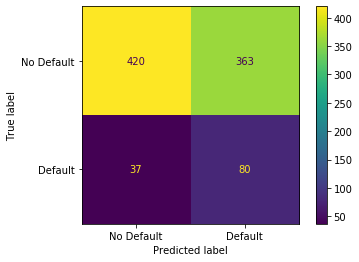

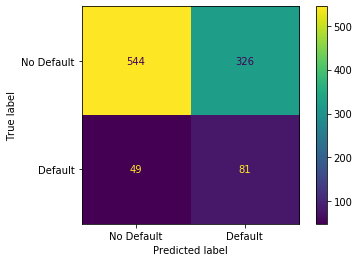

In [179]:
# Validation set confusion matrix
plot_confusion_matrix(optimized_classifier,
                      X_val,
                      y_val,
                      values_format='d',
                      display_labels=["No Default",
                                      "Default"])
plt.savefig('plots/validation_set_cm.png')

# Test set confusion matrix
plot_confusion_matrix(optimized_classifier,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["No Default",
                                      "Default"])
plt.savefig('plots/test_set_cm.png')


### 9.1.2 Model Evaluation

In [169]:
# Model evaluation - Test-Validation Set
print('Validation Set Metrics: ')
print('-----------------------')
y_pred_val = optimized_classifier.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val)
accuracy = accuracy_score(y_val, y_pred_val)
print('Confusion matrix: \n', cm)
print('\nF1 Score: ', 2*cm[1, 1]/(2*cm[1, 1]+cm[0, 1]+cm[1, 0]))
print('\nPrecision: ', cm[1, 1]/(cm[1, 1]+cm[0, 1]))
print('\nAccuracy: ', accuracy)
print('\nRecall/Sensitivity: ', cm[1, 1]/(cm[1, 1]+cm[1, 0]))
print('\nSpecificity: ', cm[0, 0]/(cm[0, 0]+cm[0, 1]))

print('\n')
print('Test Set Metrics: ')
print('-----------------')
y_pred_test = optimized_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
print('Confusion matrix: \n', cm)
print('\nF1 Score: ', 2*cm[1, 1]/(2*cm[1, 1]+cm[0, 1]+cm[1, 0]))
print('\nPrecision: ', cm[1, 1]/(cm[1, 1]+cm[0, 1]))
print('\nAccuracy: ', accuracy)
print('\nRecall/Sensitivity: ', cm[1, 1]/(cm[1, 1]+cm[1, 0]))
print('\nSpecificity: ', cm[0, 0]/(cm[0, 0]+cm[0, 1]))


Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[420 363]
 [ 37  80]]

F1 Score:  0.2857142857142857

Precision:  0.18058690744920994

Accuracy:  0.5555555555555556

Recall/Sensitivity:  0.6837606837606838

Specificity:  0.5363984674329502


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[544 326]
 [ 49  81]]

F1 Score:  0.3016759776536313

Precision:  0.19901719901719903

Accuracy:  0.625

Recall/Sensitivity:  0.6230769230769231

Specificity:  0.6252873563218391


### 9.1.3 Get important features

In [170]:
importance = optimized_classifier.feature_importances_

feature_index = []
feature_importance = []
for i, j in enumerate(importance):
    if j > 0.01:
        feature_index.append(i)
        feature_importance.append(j)
    pass

print('Important feature index: \n', feature_index)
print('\nFeature importance: \n', feature_importance)
print('\nCount important features: ', len(feature_index))

Important feature index: 
 [6, 18, 20, 22, 30, 31, 32, 42, 74, 83, 87, 90, 115, 116, 119, 122, 123, 124, 4285, 4406, 4574, 4692, 5624, 5712, 5717, 7926, 8699, 9032, 9105, 9908, 10492, 11303]

Feature importance: 
 [0.017694134, 0.020947592, 0.0217499, 0.023506762, 0.1603192, 0.031569265, 0.018961912, 0.010339364, 0.01676039, 0.011710086, 0.022139465, 0.024592381, 0.02790416, 0.031488918, 0.026027642, 0.016249353, 0.039685972, 0.035900027, 0.026059238, 0.014282656, 0.015225653, 0.0222555, 0.019980475, 0.015293136, 0.013277457, 0.031197282, 0.014208814, 0.016461423, 0.01839219, 0.024060281, 0.021741292, 0.015408552]

Count important features:  32


In [171]:
print('Categorical Features: ', cat_x_train.shape[1])
print('Numerical Features: ', num_x_train.shape[1])
print('Text Features: ', text_x_train.shape[1])

Categorical Features:  115
Numerical Features:  13
Text Features:  14423


In [21]:
# Index of text and categorical features
# text_feature = [2926, 3573, 3658, 3730, 3953, 4115, 4260, 4324, 4392, 4977, 5480, 5698, 6423, 6471, 6829, 6957, 7348, 7362, 8257, 8701, 9017, 9574, 9733]
# numerical_features = [ 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 124]
# categorical_feature = [6, 7, 18, 20, 21, 22, 23, 29, 30, 36, 41, 72, 81, 82, 88, 109]


In [22]:
# Index of text and categorical features - Without Lemmatizer
# text_feature = [2926, 3574, 3661, 3733, 4263, 4395, 5503, 5707, 6072, 6174, 6431, 6478, 6966, 8266, 8714, 9148, 9433, 9745]
# numerical_features = [113, 114, 115, 116, 119, 120, 121, 122, 123, 124]
# categorical_feature = [18, 20, 22, 29, 30, 36, 63, 72, 82, 88]


In [172]:
# Index of text and categorical features - Without Stemming
text_feature = [i for i in feature_index if i > (cat_x_train.shape[1] + num_x_train.shape[1])]
numerical_features = [i for i in feature_index if (i >= cat_x_train.shape[1] and i < (cat_x_train.shape[1] + num_x_train.shape[1]))]
categorical_feature = [i for i in feature_index if i < cat_x_train.shape[1]]


In [173]:
print(categorical_feature)
print(numerical_features)
print(text_feature)

[6, 18, 20, 22, 30, 31, 32, 42, 74, 83, 87, 90]
[115, 116, 119, 122, 123, 124]
[4285, 4406, 4574, 4692, 5624, 5712, 5717, 7926, 8699, 9032, 9105, 9908, 10492, 11303]


### 9.1.4 Get Important Feature Names

In [174]:
# Important categorical feature names
cat_feature_names = ohe.get_feature_names(['emp_title', 'home_ownership', 
                                           'verification_status', 
                                           'purpose_cat', 'addr_state', 
                                           'policy_code', 'quarter', 
                                           'year'])

imp_categorical_features = []
for i, j in enumerate(cat_feature_names):
    if i in categorical_feature:
        imp_categorical_features.append(j)

print('Important categorical feature: \n')
imp_categorical_features

Important categorical feature: 



['emp_title_None',
 'verification_status_VERIFIED - income',
 'verification_status_not verified',
 'purpose_cat_credit card',
 'purpose_cat_other small business',
 'purpose_cat_small business',
 'purpose_cat_wedding',
 'addr_state_FL',
 'addr_state_TX',
 'policy_code_PC2',
 'quarter_1',
 'quarter_4']

In [175]:
# Important text feature name
feature_name = tf.get_feature_names()

imp_text_features = []
for i, j in enumerate(feature_name):
    if i+128 in text_feature:
        imp_text_features.append('word_'+j)

print('Important word features: \n')
imp_text_features
        

Important word features: 



['word_bills',
 'word_borrower',
 'word_business',
 'word_card',
 'word_credit',
 'word_current',
 'word_currently',
 'word_help',
 'word_job',
 'word_like',
 'word_loan',
 'word_need',
 'word_pay',
 'word_rate']

In [176]:
# Important numerical feature name
num_features = ['emp_length', 'annual_inc', 'debt_to_income', 
                'delinq_2yrs','inq_last_6mths', 'open_acc', 
                'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
                'mths_since_last_major_derog', 'mths_since_last_record', 
                'mths_since_last_delinq']

imp_numerical_features = []
for i, j in enumerate(num_features):
    if i+115 in numerical_features:
        imp_numerical_features.append(j)
       
print('Important numerical features: \n')
imp_numerical_features

Important numerical features: 



['emp_length',
 'annual_inc',
 'inq_last_6mths',
 'revol_bal',
 'revol_util',
 'total_acc']

### 9.1.5 Visualize important features

In [177]:
feature_names = imp_categorical_features + imp_numerical_features + imp_text_features

feature_dat = {'Index': feature_index, 
               'Feature_Name': feature_names, 
               'Feature_imp': feature_importance}

feature_imp_df = pd.DataFrame(feature_dat)
feature_imp_df = feature_imp_df.sort_values('Feature_imp', ascending=True)

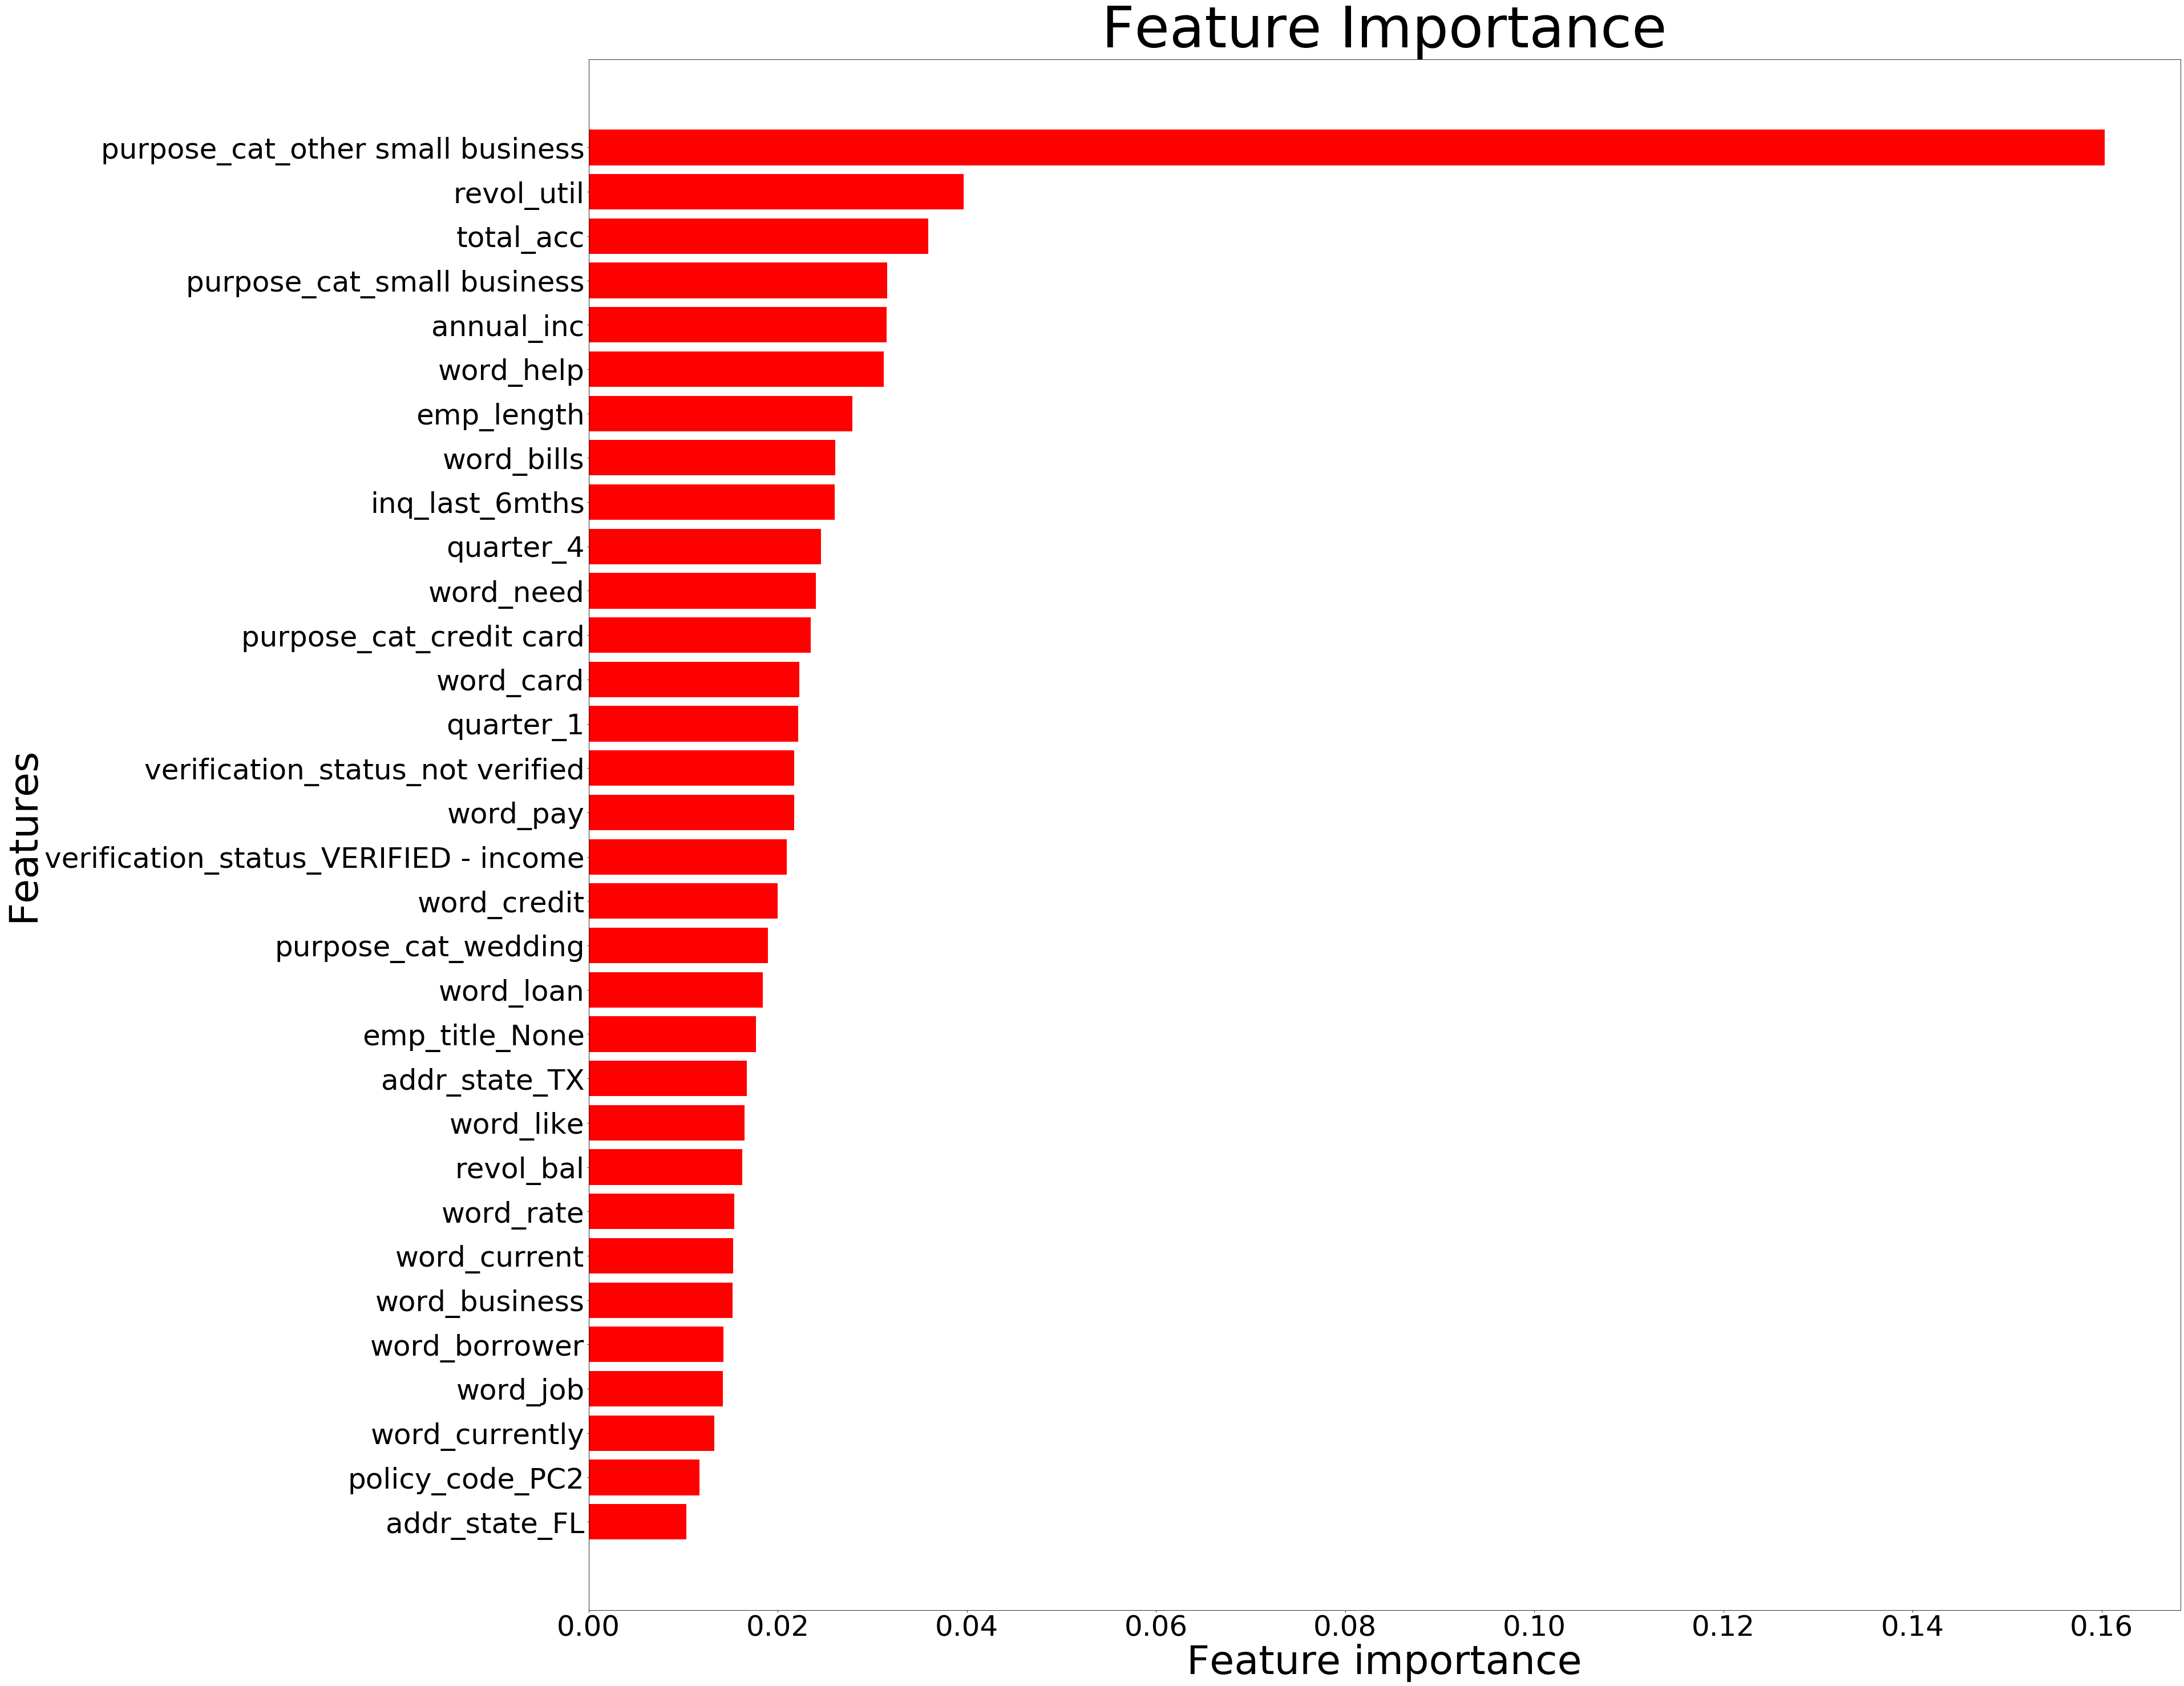

In [178]:
fig, ax = plt.subplots()
fig.set_figheight(50)
fig.set_figwidth(50)
plt.title('Feature Importance', fontsize=100)
plt.barh(feature_imp_df['Feature_Name'], feature_imp_df['Feature_imp'],
         color='red')
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlabel("Feature importance", fontsize=70)
plt.ylabel("Features", fontsize=70)
plt.savefig('plots/feature_imp.png')
plt.show()

In [ ]:
X_train = X_train[:,feature_index]
X_val = X_val[:,feature_index]
X_test = X_test[:,feature_index]

## 9.2 Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, 
                             criterion='gini',
                             class_weight={0:1,1:7},
                             max_depth=10,
                             random_state=10)

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 7}, max_depth=10, random_state=10)

### 9.2.1 Confusion Matrix

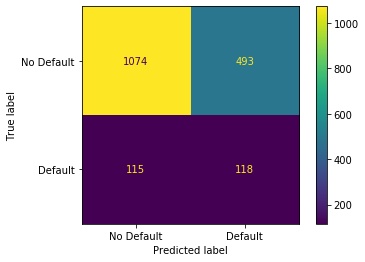

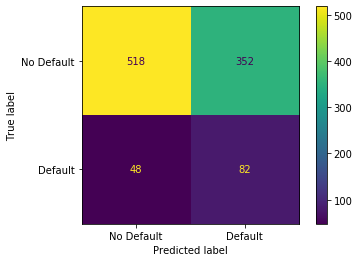

In [30]:
plot_confusion_matrix(rfc,
                      X_val,
                      y_val,
                      values_format='d',
                      display_labels=["No Default",
                                      "Default"])

plot_confusion_matrix(rfc,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["No Default",
                                      "Default"])


### 9.2.2 Model Evaluation

In [31]:
# Model evaluation - Test-Validation Set
print('Validation Set Metrics: ')
print('-----------------------')
y_pred_val = rfc.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val)
accuracy = accuracy_score(y_val, y_pred_val)
print('Confusion matrix: \n', cm)
print('\nF1 Score: ', 2*cm[1, 1]/(2*cm[1, 1]+cm[0, 1]+cm[1, 0]))
print('\nPrecision: ', cm[1, 1]/(cm[1, 1]+cm[0, 1]))
print('\nAccuracy: ', accuracy)
print('\nRecall/Sensitivity: ', cm[1, 1]/(cm[1, 1]+cm[1, 0]))
print('\nSpecificity: ', cm[0, 0]/(cm[0, 0]+cm[0, 1]))

print('\n')
print('Test Set Metrics: ')
print('-----------------')
y_pred_test = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
print('Confusion matrix: \n', cm)
print('\nF1 Score: ', 2*cm[1, 1]/(2*cm[1, 1]+cm[0, 1]+cm[1, 0]))
print('\nPrecision: ', cm[1, 1]/(cm[1, 1]+cm[0, 1]))
print('\nAccuracy: ', accuracy)
print('\nRecall/Sensitivity: ', cm[1, 1]/(cm[1, 1]+cm[1, 0]))
print('\nSpecificity: ', cm[0, 0]/(cm[0, 0]+cm[0, 1]))


Validation Set Metrics: 
-----------------------
Confusion matrix: 
 [[1074  493]
 [ 115  118]]

F1 Score:  0.2796208530805687

Precision:  0.19312602291325695

Accuracy:  0.6622222222222223

Recall/Sensitivity:  0.5064377682403434

Specificity:  0.6853860880663688


Test Set Metrics: 
-----------------
Confusion matrix: 
 [[518 352]
 [ 48  82]]

F1 Score:  0.2907801418439716

Precision:  0.1889400921658986

Accuracy:  0.6

Recall/Sensitivity:  0.6307692307692307

Specificity:  0.5954022988505747
